In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
# time.sleep(120)

In [3]:
total_count = 8


In [4]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [5]:
# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [6]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['15.206.93.7',
  '15.207.85.226',
  '3.111.218.91',
  '13.127.135.206',
  '13.234.113.254',
  '13.233.178.10',
  '65.2.152.184',
  '65.2.149.3',
  '13.233.167.114',
  '52.66.214.33',
  '3.108.190.72',
  '13.235.0.11',
  '13.232.213.53'],
 13)

In [7]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-15-206-93-7.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-207-85-226.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-111-218-91.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-127-135-206.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-234-113-254.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-178-10.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-152-184.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-149-3.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-167-114.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-52-66-214-33.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-108-190-72.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-235-0-11.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-232-213-53.

In [8]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

2


(['13.235.0.11', '13.232.213.53'],
 ['13.233.167.114', '52.66.214.33', '3.108.190.72'])

In [9]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [10]:
## First Time Setup

lines, len(lines)

(['15.206.93.7',
  '15.207.85.226',
  '3.111.218.91',
  '13.127.135.206',
  '13.234.113.254',
  '13.233.178.10',
  '65.2.152.184',
  '65.2.149.3',
  '13.233.167.114',
  '52.66.214.33',
  '3.108.190.72',
  '13.235.0.11',
  '13.232.213.53'],
 13)

In [11]:
# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-3-108-190-72.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.


[None, None, None, None, None, None, None, None, None, None, None, None, None]


In [12]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
fatal: destination p

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubu

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Reading package lists...
Building dependency tree...Reading package lists...Reading package lists...

Building dependency tree...
Reading state information...
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Reading package lists...Reading package lists...
Building dependency tree...
Reading package lists...Building dependency tree...
Building dependency

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Reading state information...

Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Reading package lists...
Building dependency tree...

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...



Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://ap-south-1.ec2.archive

Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [152 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.1 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [768 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [139 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.3 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [3

Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.3.0-1ubuntu1~22.04 [48.3 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.3.0-1ubuntu1~22.04 [126 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.3.0-1ubuntu1~22.04 [30.2 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.3.0-1ubuntu1~22.04 [10.4 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libasan6 amd64 11.4.0-1ubuntu1~22.04 [2282 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:8 http://ap-south-1.ec2.ar

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libc-dev-bin.
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 64.5 MB in 4s (15.4 MB/s)
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../gcc-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../19-libubsan1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libg

Selecting previously unselected package fontconfig-config.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package g++.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package make.Selecting previously unselected package gcc.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../24

Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.9ubuntu3) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up lto-disabled-list (24) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up l

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Reading package lists...
Building dependency tree...
Running kernel seems to be up-to-date.


Reading state information...
Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcurl4
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Fetched 484 kB in 1s (958 kB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
The following packages will be upgraded:
  curl libcurl4
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
2 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Need to get 484 kB of archives.
After this o

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Fetched 484 kB in 0s (1110 kB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81

job.sh: 11: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `

job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certific

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Fetched 46.4 MB in 2s (20.4 MB/s)
Selecting previously unselected package alsa-topology-conf.
Get:11 http://ap-south-1.ec2.arc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://ap-so

Adding debian:GlobalSign_Root_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1

Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:Izenpe.com.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.p

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 46.4 MB in 15s (3116 kB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2

Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Instit

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [13]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such 

[None, None, None, None, None, None, None, None, None, None, None, None, None]


In [14]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava



> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes


> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:unchecked for details.


.......Starting a Gradle Daemon (subsequent builds will be faster)
.................10%..........10%..10%....................20%..............20%....30%.....20%......................30%....40.%........30..%.................40%........50%..40%......................50%......60%.....50%.....................70%.....60%..........60%.................70%..80%...........70%...................80%.....90%.......80%.....................100%
90%............90%........100%
.......100%

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 13s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 21s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory

rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such 

[None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory


In [16]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(8, 2)

In [ ]:
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

In [17]:
def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.40.108 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
        os.system(command)   
        
        
def join_node2(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.36.238 11090 11091 config0 >../nohup_j2.out 2>&1 &"'
        
        
        os.system(command)
        
        
def join_node3(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 172.31.41.136 11100 11101 config0 >../nohup_j3.out 2>&1 &"'
        
        
        os.system(command)   
        
        
# def join_node4(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 11 172.31.25.228 11110 11111 1 config1 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)           


        
        

In [22]:
experiment = 'MultiJoinRun_tot_'+str(total_count)+'_clusters_'+str(nclusters) 
        
        
        
        
        
        
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)

        


print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(30)


join_node1(8)
time.sleep(20)


join_node2(9)
time.sleep(20)




join_node3(10)
time.sleep(20)


# time.sleep(50)
check_node(10)

# time.sleep(100)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': N

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated AP


> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :jar

> Task :processResources NO-SOURCE

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (su

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView'rm: cannot remove 'config/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config/currentView': No such file or directory

rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView'

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 11071, /172.31.41.210, 172.31.41.210
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@3f56875e
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@3e96bacf
-- getConnection HERE 
-- Getting connection for ret: null,

config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 11101, /172.31.41.136, 172.31.41.136
-- ID = 10
-- N = 4
-- F = 1
-- Port (client <-> server) = 11100
-- Port (server <-> server) = 11101
-- requestTimeout = 50000
-- maxBatch = 1
-- Binded replica to IP address 172.31.41.136
-- SSL/TLS enabled, protocol version: TLSv1.2
-- Not in current view: ID:0; F:1; Processes:0(/172.31.32.86:11000),1(/172.31.41.221:11010),2(/172.31.40.245:11020),3(/172.31.47.214:11030),
-- Waiting for the TTP: ID:0; F:1; Processes:0(/172.31.32.86:11000),1(/172.31.41.221:11010),2(/172.31.40.245:11020),3(/172.31.47.214:11030),


nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found


In [23]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps[:1]:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove 'MultiJoinRun_tot_8_clusters_2.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-13-235-0-11.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/MultiJoinRun_tot_8_clusters_2/nohup_client_11.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-13-232-213-53.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/MultiJoinRun_tot_8_clusters_2/nohup_client_12.out


In [24]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

 2 sec: 8 operations; 8 current ops/sec; [UPDATE AverageLatency(us)=116475.88] 
 116475.88 8 2
 3 sec: 42 operations; 33.93 current ops/sec; [UPDATE AverageLatency(us)=28901.82] 
 28901.82 33.93 3
 4 sec: 84 operations; 42 current ops/sec; [UPDATE AverageLatency(us)=23991.1] 
 23991.1 42 4
 5 sec: 132 operations; 47.95 current ops/sec; [UPDATE AverageLatency(us)=20772.06] 
 20772.06 47.95 5
 6 sec: 194 operations; 62 current ops/sec; [UPDATE AverageLatency(us)=16226.1] 
 16226.1 62 6
 7 sec: 267 operations; 73 current ops/sec; [UPDATE AverageLatency(us)=13602.71] 
 13602.71 73 7
 8 sec: 343 operations; 75.92 current ops/sec; [UPDATE AverageLatency(us)=13138.67] 
 13138.67 75.92 8
 9 sec: 419 operations; 76 current ops/sec; [UPDATE AverageLatency(us)=13157.47] 
 13157.47 76 9
 10 sec: 499 operations; 79.92 current ops/sec; [UPDATE AverageLatency(us)=12523.5] 
 12523.5 79.92 10
 11 sec: 580 operations; 81 current ops/sec; [UPDATE AverageLatency(us)=12380.72] 
 12380.72 81 11
 12 sec: 666

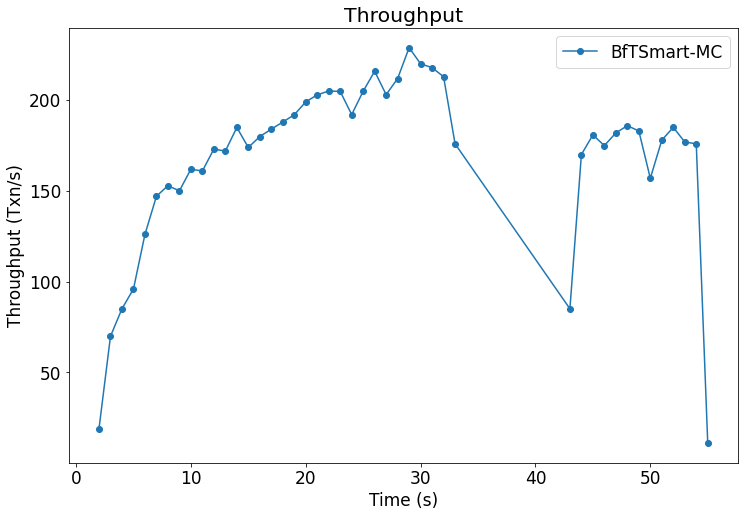

In [25]:
PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


# pl.title(r'Latency')


# pl.xlabel('Time (s)')
# pl.ylabel('Latency (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
# pl.show()

In [26]:
# ## Join Experiment

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))



# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))



# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 



# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  



# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # print(results)  


# # time.sleep(80)
# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # for i in [0,1,4,8,12,13,14]:
# # # for i in [1]:
    
# #     ip = lines[i]
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup'+str(i)+'.out'


# #         os.system(command)

# check_node(11)

# portStart = 11000 + len(nodeIps)*10

# join_lines = []
# currentPort = portStart

# for i in range(len(no_cluster_yet_nodes)):
#     line = str(len(nodeIps)+i) + ' ' + no_cluster_yet_nodes[i] + ' ' + str(currentPort) + ' '+ str(currentPort+1)
#     currentPort = currentPort + 10
#     join_lines.append(line)
#     print('server',line)

# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.31.236 11080 11081 config0
# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.23.57 11090 11091 config1

# ## KILL ALL JAVA



# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ## JOIN COMMAND





# def run_join_client(i):
    
    
    
#     ip = lines[-2]
#     if ip!='None':
#         current = (ip.split('.'))
        
#         join_commands = join_command(i)
        
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmarto; '+join_commands+'"'
        
#         print(command)
#         os.system(command)

echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-15-206-93-7.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-15-207-85-226.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-235-0-11.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-233-178-10.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-234-113-254.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-3-111-218-91.ap-south-1.compute.amazonaws.com:commands.sh
ec

In [ ]:
# ## JOIN EXPERIMENT

# check_node(3)

# # t1 = time.time()
# # time.sleep(3)
# # t2 = time.time()

# import time
# JoinTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(40)

# for i in range(4,8):
#     print(i)
#     JoinTimes.append(time.time() - t_start)
#     run_join_client(i)
#     time.sleep(40)
    

# check_node(7)


# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ip

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out data/MultipleJoins/nohup.out'


#     os.system(command)




# import numpy as np
# import pylab as pl

# times ,thputs, lats = getTimesThputs('data/MultipleJoins/nohup.out')

# JoinTimes

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10], '-o', label='Existing nodes')


# pl.title(r'Throughput with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()



# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# # pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10]*lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency*thput with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()